### [View on nbviewer](https://nbviewer.jupyter.org/github/chrisluedtke/divvy-data-analysis/blob/master/notebook.ipynb)

In [16]:
import os

%matplotlib inline
import folium
import folium.plugins
import matplotlib as plt
import numpy as np
import pandas as pd

import divvy

In [2]:
plt.style.use('seaborn')

### Initial Data Sourcing

In [3]:
# rides, stations = divvy.historical_data.get_data(
#     year=[str(_) for _ in range(2013,2019)],
#     rides=True, 
#     stations=True
# )

In [4]:
# rides.to_pickle('data/rides.pkl')
# stations.to_pickle('data/stations.pkl')

### Load from Pickle

In [3]:
rides = pd.read_pickle('data/rides.pkl')
# drop unused cols to save space
rides = rides.drop(columns=['from_station_name', 'to_station_name'])

In [4]:
stations = pd.read_pickle('data/stations.pkl')

### Exploration

In [4]:
rides.columns

Index(['bikeid', 'birthyear', 'end_time', 'from_station_id',
       'from_station_name', 'gender', 'start_time', 'to_station_id',
       'to_station_name', 'trip_id', 'tripduration', 'usertype'],
      dtype='object')

In [5]:
rides.isna().sum()

bikeid                     0
birthyear            4328042
end_time                   0
from_station_id            0
from_station_name          0
gender               4335754
start_time                 0
to_station_id              0
to_station_name            0
trip_id                    0
tripduration               0
usertype                   0
dtype: int64

count    6386.000000
mean     2728.678359
std       871.209718
min         2.000000
25%      2059.250000
50%      2779.500000
75%      3427.000000
max      5164.000000
Name: bikeid, dtype: float64


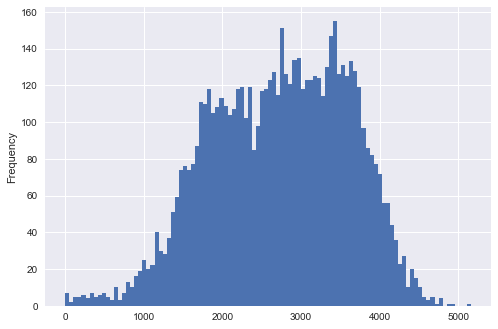

In [11]:
# How many times has each bike been ridden?
bike_use = rides['bikeid'].value_counts()
print(bike_use.describe())
bike_use.plot.hist(bins=100);

In [12]:
def get_all_groups(how='Q', start='2013-01-01', end='2018-12-31'):
    all_dates = pd.date_range(start, end, freq='D')
    all_dates = (pd.Series(all_dates)
                   .dt.to_period(how)
                   .drop_duplicates())
    
    return pd.Series(data=0, index=all_dates)

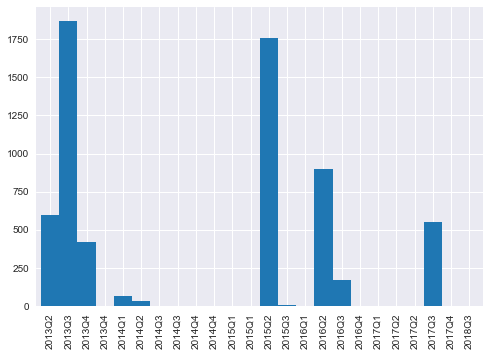

In [13]:
# Count of first month bike used
color=(31/256,119/256,180/256,1)

frst_use = (rides.groupby('bikeid')['start_time'].first()
                 .dt.to_period("Q"))
frst_use.name = 'first_use_quarter'

data = frst_use.value_counts()

data = data.append(get_all_groups(how='Q'))
data = (data.sort_values(ascending=False)
            .loc[~data.index.duplicated(keep='first')]
            .sort_index())

data.plot.bar(color=color, width=1);

In [ ]:
# color bike usage by quarter first ridden
rides = rides.merge(frst_use.astype(str), left_on='bikeid',
                    right_on=frst_use.index)

In [10]:
cols = ['first_use_quarter', 'bikeid']
bike_use = rides[cols].sort_values('first_use_quarter')

bike_use_grp = (bike_use.groupby('first_use_quarter')['bikeid'].value_counts()
                        .reset_index(name='n_rides')
                        .drop(columns='bikeid'))

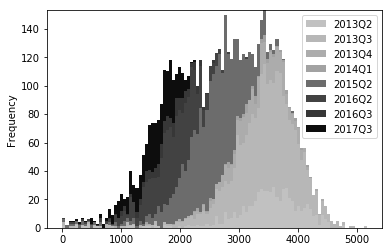

In [147]:
color_dict = {}
all_groups = get_all_groups()

for i, v in enumerate(all_groups.index):
    color_dict[str(v)] = (
        .8-i/len(all_groups), 
        .8-i/len(all_groups), 
        .8-i/len(all_groups), 
        1
    )
    
colors = [color_dict.get(group) for group in bike_use_grp.first_use_quarter.unique()]

d = {}
for k, v in bike_use_grp.groupby('first_use_quarter').n_rides:
    if len(v) > 31:
        d[k] = v
        
hist = pd.DataFrame(d)

hist.plot.hist(bins=100, stacked=True, color=[color_dict[col] for col in hist.columns]);

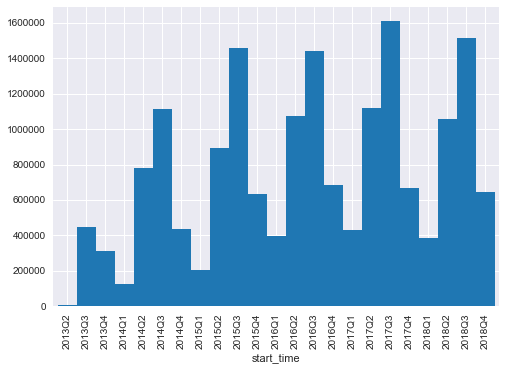

In [14]:
# Count of quarterly rides
(rides['start_time'].groupby([rides.start_time
                                   .dt.to_period("Q")])
                    .count()
                    .plot.bar(color=color, width=1));

In [6]:
rides.tripduration.describe()

count    1.742534e+07
mean     1.092654e+03
std      1.643426e+04
min      6.000000e+01
25%      4.110000e+02
50%      7.060000e+02
75%      1.197000e+03
max      1.433640e+07
Name: tripduration, dtype: float64

In [58]:
rides.tripduration.sum()

19039869991.0

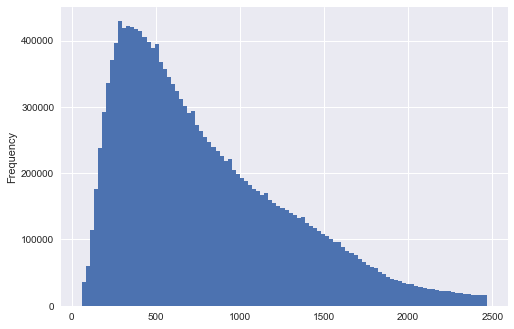

In [15]:
# How long are trips?
(rides.tripduration.loc[rides.tripduration < rides.tripduration.quantile(.95)]
                   .plot.hist(bins=100));

In [60]:
sum_duration_bike = rides.groupby('bikeid')['tripduration'].sum()
sum_duration_bike.describe()

count    6.386000e+03
mean     2.981502e+06
std      1.232961e+06
min      1.331000e+03
25%      2.201847e+06
50%      2.960164e+06
75%      3.648085e+06
max      1.793377e+07
Name: tripduration, dtype: float64

## Get Station Coordinates

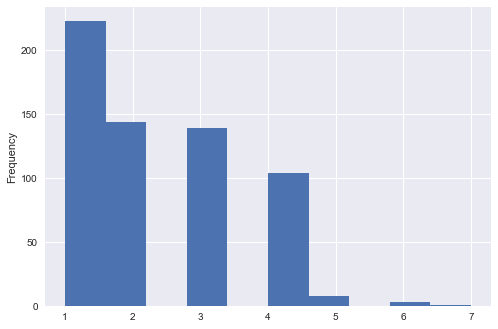

In [5]:
# Stations have moved
(stations.drop_duplicates(['id', 'latitude', 'longitude'])
         .groupby('id')['id'].count()
         .plot.hist());

Unfortunately, Divvy kept the same station ID while physically moving those stations around. This adds a lot of complexity to route analysis, and it makes certain analyses impossible.

One approach may be to round lat/lon coordinates to some [degree of precision](https://en.wikipedia.org/wiki/Decimal_degrees#Precision), and then remove duplicates on rounded position. While that may seem to reduce the problem, there would be no way to determine whether a station initially at position A, moved to position B, and then back to position A.

Another approach is to calculate the rolling difference of lat/lon coordinates and filter out differences below a desired precision. Let's do that.

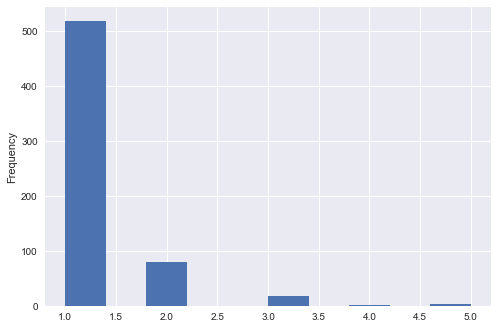

In [6]:
fix_stns = stations.copy()
diffs = (fix_stns.sort_values('source')
                 .groupby('id')
                 .agg({'latitude':'diff',
                       'longitude':'diff'})
                 .assign(sum_diff=lambda df: abs(df.latitude) + 
                                             abs(df.longitude))
                 .drop(columns=['latitude', 'longitude']))

fix_stns = pd.concat([fix_stns, diffs], axis=1)
# NaNs are first instance, so keep those
fix_stns = fix_stns.loc[fix_stns.sum_diff.isna() | (fix_stns.sum_diff > 0.0005)]

dupe_counts = fix_stns.groupby('id')['id'].count()
dupe_counts.plot.hist();

We can assess the problem by plotting stations that have moved:

In [23]:
df = fix_stns.loc[fix_stns.id.duplicated(keep=False), 
              ['id', 'latitude', 'longitude', 
               'online_date', 'source']]

m = folium.Map(location=[df.latitude.mean(), 
                         df.longitude.mean()],
               tiles='CartoDB dark_matter',
               zoom_start=12)

grouped = df.groupby('id')
for k, v in grouped:
    points = list(zip(v.latitude, v.longitude))
    folium.PolyLine(
        points, tooltip=str(v.id.values[0]),
        color="#E37222", weight=1
    ).add_to(m)
    
folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)
    
m

In [24]:
# m.save('moved.html')

In [30]:
print(grouped.get_group(2).to_string(index=False))

 id   latitude  longitude         online_date     source
  2  41.872293 -87.624091                 NaT       2015
  2  41.881060 -87.619486 2013-06-10 10:43:46  2017_Q1Q2
  2  41.876393 -87.620328 2013-06-10 10:43:00  2017_Q3Q4


In [ ]:
# print(grouped.get_group(2).to_html(index=False))

From here I would create a lookup table for stations that have moved. The rows would span each day the station was active, and I would merge with my `rides` table on a `ride_id_date` key. Here's the start to that process:

In [18]:
# station_dates = pd.concat([rides[['start_time', 'to_station_id']].rename(columns={'to_station_id':'station_id'}), 
#                            rides[['start_time', 'from_station_id']].rename(columns={'from_station_id':'station_id'})], 
#                           ignore_index=True)

# station_dates = (station_dates.sort_values('start_time')
#                               .groupby('station_id')
#                               .agg({'start_time':['min', 'max']}))

But for now, I'll average each duplicated station's lat/lon positions to make things easy.

In [7]:
stations = (fix_stns.groupby('id')['latitude', 'longitude']
                .mean())

## Merge Station Coordinates

In [8]:
rides = (rides.merge(stations.rename(columns={'latitude':'from_lat',
                                              'longitude':'from_lon'}),
                     left_on='from_station_id', right_index=True,
                     how='left')
              .merge(stations.rename(columns={'latitude':'to_lat',
                                              'longitude':'to_lon'}),
                     left_on='to_station_id', right_index=True,
                     how='left'))

## Calculate Distances

In [34]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371000):
    """
    Vectorized great circle distance between two points
    (lat, lon) specified in decimal degrees or in radians)
    Returns units in meters
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [35]:
rides['dist'] = haversine(rides.from_lat, rides.from_lon, rides.to_lat, rides.to_lon)

In [38]:
rides['taxi_dist'] = (haversine(rides.from_lat, rides.from_lon, 
                                rides.from_lat, rides.to_lon) + 
                      haversine(rides.to_lat, rides.to_lon, 
                                rides.from_lat, rides.to_lon))

## Descriptives Involving Distance

In [36]:
rides.dist.describe()

count    1.742475e+07
mean     2.005762e+03
std      1.587529e+03
min      0.000000e+00
25%      9.254459e+02
50%      1.548781e+03
75%      2.646230e+03
max      3.679380e+04
Name: dist, dtype: float64

In [ ]:
rides.dist.loc[(1 < rides.dist)].describe()

In [41]:
rides.dist.sum()

34949897843.20045

In [ ]:
rides.taxi_dist.describe()

In [50]:
rides.taxi_dist.loc[(1 < rides.taxi_dist)].describe()

count    1.678981e+07
mean     2.594327e+03
std      1.982312e+03
min      1.306022e+02
25%      1.218784e+03
50%      1.997151e+03
75%      3.381158e+03
max      4.167998e+04
Name: taxi_dist, dtype: float64

In [57]:
rides.taxi_dist.sum()

43558272057.5074

In [47]:
rides.dropna().sort_values('taxi_dist').tail(1)

,bikeid,birthyear,end_time,from_station_id,from_station_name,gender,start_time,to_station_id,to_station_name,trip_id,tripduration,usertype,from_lat,from_lon,to_lat,to_lon,dist,taxi_dist
16018352,252,1986.0,2018-08-12 15:27:11,595,Wabash Ave & 87th St,Male,2018-08-12 12:35:02,602,Central St & Girard Ave,20104775,10329.0,Subscriber,41.736646,-87.622634,42.064156,-87.686057,36793.795045,41679.976906


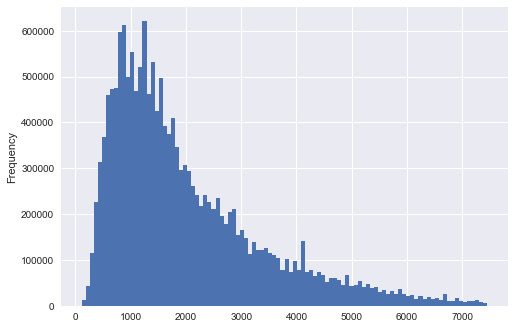

In [45]:
(rides.dist.loc[(1 < rides.dist) &
                (rides.dist < rides.dist.quantile(.99))]
     .plot.hist(bins=100));

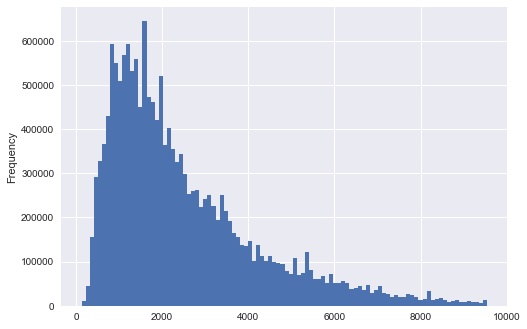

In [51]:
(rides.taxi_dist.loc[(1 < rides.taxi_dist) &
                     (rides.taxi_dist < rides.taxi_dist.quantile(.99))]
      .plot.hist(bins=100));

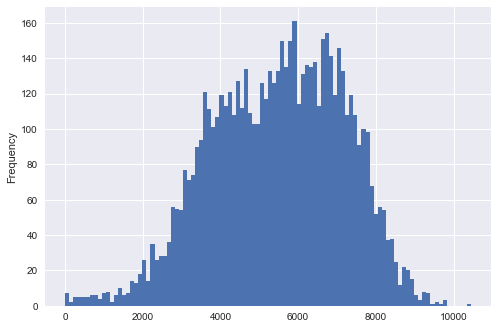

In [53]:
# sum distance ridden
dist_sum = rides.groupby('bikeid')['dist'].sum().divide(1000)
dist_sum.plot.hist(bins=100);

In [54]:
dist_sum.sort_values(ascending=False)

bikeid
410     10451.034962
1315     9785.608171
1385     9743.838634
73       9726.479546
877      9642.728393
2240     9586.680666
774      9537.659454
555      9417.218802
1445     9405.346914
94       9380.165405
2241     9370.453664
2147     9368.991225
1487     9361.754246
2155     9361.315722
1378     9356.319125
238      9289.824865
1876     9283.878905
2283     9279.702646
1735     9264.411279
688      9253.965965
1587     9236.256683
1136     9229.251760
579      9215.316213
421      9182.588288
473      9148.954574
1774     9142.743539
1245     9084.495100
1796     9051.738711
414      9044.715829
872      9024.249290
            ...     
5596      646.147172
6121      612.479608
4265      606.424150
6428      606.294858
5869      547.247352
842       529.852904
6063      522.370701
4212      485.359022
4321      454.732640
335       453.007622
2351      432.142886
1551      414.484579
5147      398.582973
6413      361.533281
4014      355.692798
4155      329.369938
5364  

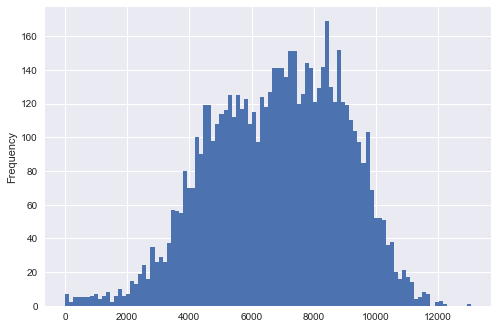

In [55]:
# sum distance ridden
taxi_dist_sum = rides.groupby('bikeid')['taxi_dist'].sum().divide(1000)
taxi_dist_sum.plot.hist(bins=100);

In [56]:
taxi_dist_sum.sort_values(ascending=False)

bikeid
410     13063.972254
1315    12191.970222
1385    12142.423774
73      12105.943256
877     12046.194041
2240    12004.431617
774     11892.543628
555     11751.877938
1445    11718.628333
2155    11708.674415
2241    11686.223361
1487    11672.902920
2147    11671.106033
94      11666.443247
1378    11625.652182
1876    11588.913064
238     11559.040752
1735    11549.671175
2283    11531.929349
1587    11531.406224
688     11523.719975
579     11508.938088
1136    11481.764686
421     11470.724336
473     11409.366658
1774    11381.795693
1245    11366.954567
1796    11321.443311
414     11284.548913
540     11255.247128
            ...     
5596      802.659891
6121      768.428356
4265      762.643148
6428      760.167116
5869      673.756101
842       672.234573
6063      647.466644
4212      600.469841
335       564.815422
4321      562.518756
2351      538.377604
1551      517.232215
5147      502.878575
6413      455.093331
4014      443.012595
4155      410.673035
5364  

In [45]:
# Path of the farthest farthest bike
df = (rides.loc[(rides.bikeid==410)]
           .sort_values('start_time'))

points = []
for from_i, to_i, in zip(list(zip(df.from_lat, df.from_lon)), 
                         list(zip(df.to_lat, df.to_lon))):
    points.append(from_i)
    points.append(to_i)
    
m = folium.Map(location=[df.from_lat.mean(), 
                         df.from_lon.mean()],
               tiles='CartoDB dark_matter',
               zoom_start=13)

folium.PolyLine(
    points,
    weight=0.2,
    color="#E37222"
).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)

m

In [46]:
m.save('maps/longest_ridden.html')

## Check daylight savings

In [307]:
dst_start = { # clock 2AM to 3AM
    '2013':'2013-03-10',
    '2014':'2013-03-09',
    '2015':'2013-03-08',
    '2016':'2016-03-13',
    '2017':'2017-03-12',
    '2018':'2018-03-11',
}

dst_end = { # clock 2AM to 1AM
    '2013':'2013-11-03',
    '2014':'2014-11-02',
    '2015':'2015-11-01',
    '2016':'2016-11-06',
    '2017':'2017-11-05',
    '2018':'2018-11-04',
}

for year in [str(_) for _ in range(2013,2019)]:
    print(
        rides.loc[(f'{dst_start[year]} 02:00:00' < rides.start_time) &
                  (rides.start_time < f'{dst_start[year]} 02:59:59'), cols]
    )
    
print(rides.loc[(rides.end_time < rides.start_time), cols])

Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []


## Animated Plot

Seeking animated plot where circles positioned at stations, size represents station usage, and color represents type of use (gaining bikes or losing bikes).

In [9]:
def melt(df, keep_cols=[]):
    # standardize language
    df = df.rename(columns={col: (col.replace('from_', 'start_')
                                     .replace('to_', 'end_'))
                            for col in df})
    
    start_cols = [col for col in df if col.startswith('start_')]
    end_cols = [col for col in df if col.startswith('end_')]

    df = pd.concat([(df.loc[:,keep_cols + start_cols]
                       .rename(columns={col: col.replace('start_','') 
                                        for col in start_cols})
                       .assign(type='departure')),
                    (df.loc[:,keep_cols + end_cols]
                             .rename(columns={col: col.replace('end_','') 
                                              for col in end_cols})
                       .assign(type='arrival'))],
                  sort=False, axis=0)

    return df

def add_empty_rows(stn_hr_agg, expctd_elems):
    ffill_cols = ['station_id','lat','lon']
    id_cols = ['station_id', 'hour']
    nan_cols = ['avg_use','pt_departures']
    
    uniq_stns = (stn_hr_agg.loc[:, ffill_cols]
                           .drop_duplicates())
    uniq_stns.index = [1]*len(uniq_stns)

    hr_elems = pd.Series(expctd_elems, 
                         index=[1]*len(expctd_elems),
                         name='hour')
    df = (pd.merge(hr_elems, uniq_stns, 
                   left_index=True, right_index=True)
            .sort_values(id_cols)
            .reset_index(drop=True)
            .merge(stn_hr_agg[id_cols+nan_cols], on=id_cols,
                   how='outer'))
    return df

def interpolate(df: pd.DataFrame):
    # 0.033333333 is 30 frames per hour of IRL observations
    # place zero values
    set_zeros = np.linspace(0,24,24*2, endpoint=False)
    df = add_empty_rows(df, set_zeros)
    df = df.fillna(0)
    # place nan values
    set_nans = np.linspace(0,24,24*2*15, endpoint=False).round(3)
    df = add_empty_rows(df, set_nans)
    # add final frame that matches first frame
    df = (df.append((df.loc[df.hour==df.hour.min(),:]
                       .assign(hour=24))))
    # interpolate nans
    df = df.sort_values(['station_id', 'hour']).interpolate()
    return df

def hex2rgb(color:str):
    """HEX-code to decimal"""
    return tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

def dec2hex(n):
    """Decimal number to HEX str"""
    if (n > 16):
        return str(hex(n).split('x')[-1])
    else:
        return "0" + str(hex(n).split('x')[-1])

def get_gradient(start, stop, steps, include_inputs=False):
    """Gradient between hex color start and stop"""
    r, g, b = hex2rgb(start)
    r2, g2, b2 = hex2rgb(stop)
    r_step = int((r2 - r) / steps)
    g_step = int((g2 - g) / steps)
    b_step = int((b2 - b) / steps)
    
    grd_lst = []
    for i in range(steps):
        r += r_step
        g += g_step
        b += b_step
        grd_lst.append("#" + dec2hex(r) + 
                       dec2hex(g) + dec2hex(b))
    
    if include_inputs:
        return [start] + grd_lst + [stop]
    else:
        return grd_lst

In [115]:
# subsample to get a working flow before applying to large dataset
rides_sm = rides.sample(10000)

In [10]:
stn_agg = melt(rides)

stn_agg['hour'] = (stn_agg.time.dt.hour + 
                   stn_agg.time.dt.minute // 30 * 0.5)
stn_agg['dow'] = stn_agg.time.dt.dayofweek
stn_agg['month'] = (stn_agg.time.dt.year + 
                    stn_agg.time.dt.month / 12)

# Here I assume if the station was used any time in a month,
# then it was active for the entire month
stn_days = (stn_agg.groupby('station_id')['month']
                   .nunique()
                   .multiply(30)
                   .rename('days_active'))
stn_agg = stn_agg.drop(columns='month')

id_cols = ['station_id', 'lat', 'lon', 'hour']
stn_agg = (stn_agg.loc[:, id_cols+['type']]
                  .pivot_table(index=id_cols, columns='type', 
                               aggfunc='size', fill_value=0)
                  .reset_index()
                  .merge(stn_days, left_on='station_id', 
                         right_index=True))
# total_use and days_active can't be zero
stn_agg['total_use'] = (stn_agg.arrival + stn_agg.departure) 
stn_agg['avg_use'] = stn_agg.total_use.divide(stn_agg.days_active, fill_value=0)
stn_agg['pt_departures'] = stn_agg.departure.divide(stn_agg.total_use, fill_value=0.5)

In [264]:
(set(rides.to_station_id) | set(rides.from_station_id)) - set(stn_agg.station_id)

{360, 361, 363, 512}

In [265]:
(set(rides.to_station_id) | set(rides.from_station_id)) - set(stations.index)

{360, 361, 363, 512}

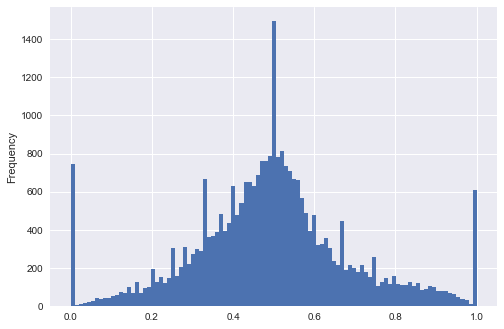

In [79]:
# dot color range
stn_agg.pt_departures.plot.hist(bins=101);

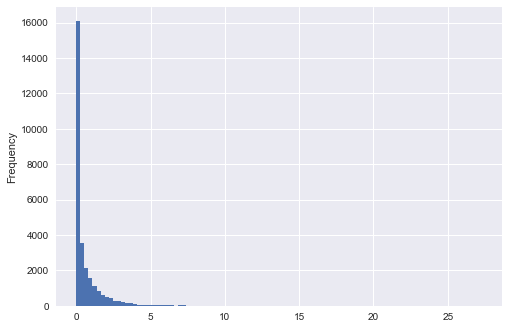

In [81]:
# dot size range
stn_agg.avg_use.plot.hist(bins=100);

In [ ]:
stn_agg[['avg_use', 'radius']].plot.scatter(x='avg_use', y='radius');

### Human Perception of Circle Size

If we directly map the radius of each station dot to the average use of the station, a dot of radius 2 will appear non-linearly larger than a dot of radius 1. However, if we set the **area** of the dot to the average use, I would argue that the average user would not perceive the the second dot as twice as large as the first. I could not find any empirical discussion on this.

https://eagereyes.org/blog/2008/linear-vs-quadratic-change

In my tests, a circle radius 60 is about the largest I would like a cirlce to appear, otherwise it obscures other information.

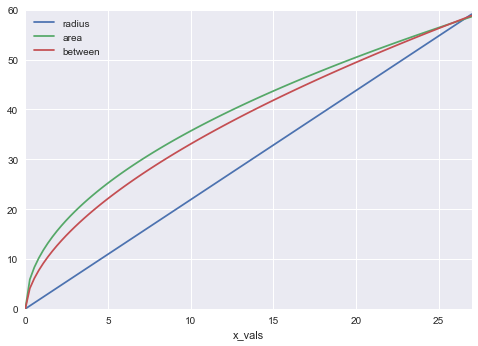

In [11]:
def radius(x):
    return x * 2.19

def area(x):
    return((x / np.pi) ** (1/2)) * 20

def between(x):
    return x ** (58/100) * 8.7

x_vals = np.linspace(0, 27, 100)
plots = pd.DataFrame({'x_vals':x_vals,
                      'radius': [radius(x) for x in x_vals],
                      'area': [area(x) for x in x_vals],
                      'between': [between(x) for x in x_vals]})
plots.plot.line(x='x_vals', xlim=(0,27), ylim=(0,60));

In [12]:
stn_agg_interp = interpolate(stn_agg)
# default percent departures is 0.5, not 0
stn_agg_interp.loc[stn_agg_interp.avg_use==0, 'pt_departures'] = 0.50

In [13]:
# Merge in color values
strt_color = "#18f0da" #blue, gathering bikes
mid_color = "#e6e6e6" #gray
end_color = "#f06e18" #orange, "radiating" bikes
start_pos = 25
mid_width = 5

steps = int((100 - start_pos * 2 - mid_width) / 2) + 1

color_list = ([strt_color] * start_pos +
              get_gradient(strt_color, mid_color, steps) + 
              [mid_color] * mid_width +
              get_gradient(mid_color, end_color, steps) + 
              [end_color] * start_pos)

gradient = pd.Series(data=color_list,
                     index=(np.linspace(0, 1, len(color_list),
                                        endpoint=True)
                              .round(2)),
                     name='color')

In [14]:
stn_agg_interp['pt_depart_rd'] = stn_agg_interp.pt_departures.round(2)
if 'color'in stn_agg_interp:
    stn_agg_interp = stn_agg_interp.drop(columns='color')
stn_agg_interp = stn_agg_interp.merge(gradient, left_on='pt_depart_rd', 
                                      right_index=True)

In [18]:
def gen_maps_by_hour(df, zoom=12, height_px=1350,
                     width_px=1350, circle_line_weight=0.5, 
                     min_radius=0, max_radius=None, show_tooltip=False,
                     preview=False, hour_preview=None,
                     save_dir=os.path.join(os.getcwd(), 'maps')):
    if not os.path.exists(save_dir) and not preview:
        os.mkdir(save_dir)
        
    if preview and hour_preview:
        df = df.loc[df.hour==hour_preview, :]
        
    grouped_df = df.groupby('hour')
    
    for group, df in grouped_df:
        m = folium.Map(location=[41.90, -87.66],
                       zoom_start=zoom,
                       width=width_px,
                       height=height_px,
                       zoom_control=False,
                       tiles="CartoDB dark_matter")

        for i, r in df.iterrows():
            if r.avg_use < 0.01:
                continue
                
            radius = min_radius + r.radius
            
            if max_radius and radius > max_radius:
                radius = max_radius
            if show_tooltip:
                tooltip=(f'Station: {r.station_id}<br>'
                         f'Average Use: {round(r.avg_use,2)}<br>'
                         f'Departures: {round(r.pt_departures*100,2)}%')
            else:
                tooltip=None
                
            folium.CircleMarker(location=(r.lat,
                                          r.lon),
                                radius=radius,
                                color=r['color'],
                                weight=circle_line_weight,
                                tooltip=tooltip,
                                fill=True).add_to(m)
        if preview:
            return m
        else:
            m.save(os.path.join(save_dir, f"{str(int(group*100)).zfill(5)}.html"))

In [84]:
stn_agg_interp['radius'] = stn_agg_interp.avg_use.apply(between)

gen_maps_by_hour(stn_agg_interp.assign(radius=lambda df: df['avg_use'].apply(between)), zoom=12, 
                 height_px=1350, width_px=int(1350*1.777), preview=True, hour_preview=3.5, show_tooltip=True)

In [85]:
def add_to_dualmap(grouped_df, m, add_to):
    for group, df in grouped_df:
        for i, r in df.iterrows():
            if r.avg_use < 0.01:
                continue
            popup_txt=(f'<h5>Station {r.station_id}</h5><br>'
                       f'Avg Uses: {round(r.avg_use,1)}<br>'
                       f'Departures: {round(r.pt_departures*100)}%')
            folium.CircleMarker(location=(r.lat,
                                          r.lon),
                                radius=r.radius,
                                color=r['color'],
                                weight=0.5,
                                popup=folium.Popup(popup_txt, max_width=500),
                                fill=True).add_to(add_to)
            
    return m

m = folium.plugins.DualMap(location=(41.89, -87.63), tiles="CartoDB dark_matter", zoom_start=14)

grouped_df = stn_agg_interp.loc[stn_agg_interp.hour==8, :].groupby('hour')
m = add_to_dualmap(grouped_df, m, m.m1)
grouped_df = stn_agg_interp.loc[stn_agg_interp.hour==17, :].groupby('hour')
m = add_to_dualmap(grouped_df, m, m.m2)

m

In [86]:
m.save('maps/am_v_pm.html')

In [9]:
# render maps to images
import os
import time
from selenium import webdriver
from PIL import Image,

maps_dir = os.path.join(os.getcwd(), 'maps')
output_dir = os.path.join(os.getcwd(), 'img', 'maps')

def render_html_maps_to_img(map_x_px, map_y_px, maps_dir, 
                            output_dir, sleep_s=3.5, ff_header_px=100):
    browser = webdriver.Firefox(executable_path='geckodriver')
    browser.set_window_size(map_x_px, map_y_px + ff_header_px)
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    for map_fn in os.listdir(maps_dir):
        map_path = os.path.join(maps_dir, map_fn)
        if map_fn.endswith('.html'):
            browser.get(f'file://{map_path}')
            time.sleep(sleep_s)

            to_fn = map_fn.replace('.html', '.png')
            to_fn = os.path.join(output_dir, to_fn)
            browser.save_screenshot(to_fn)
            print(f'Wrote: {to_fn}')
            
            if preview:
                image = Image.open(to_fn)
                browser.quit()
                return image.show()

    return browser.quit()

In [93]:
import datetime, io, random, os
from PIL import Image, ImageDraw, ImageFont

def process_images(source_dir, dest_dir, preview=False):
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    
    image_files = os.listdir(source_dir)
    
    if preview:
        image_files = random.sample(image_files, 1)
        
    time_font = ImageFont.truetype("Roboto-Thin.ttf", 120)

    for png in image_files:
        image = Image.open(os.path.join(source_dir, png))
        draw = ImageDraw.ImageDraw(image)

        hour = int(png[1:3])
        minute = round(float(png[3:5]+png[-5]+png[-5])/10000*60)

        if hour == 24:
            time_fix = (datetime.datetime(2019, 1, 1, 0, minute) + 
                        datetime.timedelta(minutes=15))
        else:
            time_fix = (datetime.datetime(2019, 1, 1, hour, minute) + 
                        datetime.timedelta(minutes=15))

    #     draw.line((image.width-200, image.height, image.width-200, 0),
    #               fill=(38, 38, 38), width=350)

        draw.text((image.width-1150,image.height-900), 
                  time_fix.strftime('%H'),
                  fill=(100, 100, 100), 
                  font=time_font)

        intended_width = image.height-585
        side_crop = (image.width-intended_width)//2
        offset = 0
        image = image.crop((side_crop+offset, 
                            0, 
                            image.width-side_crop+offset, 
                            image.height-26))
        if preview:
            return image.show()
        
        filename = os.path.join(dest_dir, (f"frame_{str(hour).zfill(2)}_"
                                           f"{str(minute).zfill(2)}.png"))
        image.save(filename, "PNG")

In [96]:
source_dir = os.path.join(os.getcwd(), r'img\maps\2019-02-07_good')
dest_dir = os.path.join(os.getcwd(), r'img\maps\2019-02-07_to_gif')
process_images(source_dir, dest_dir, preview=True)